In [84]:
from IPython import get_ipython;   
get_ipython().magic('reset -sf')

import os
os.chdir("C:/Users/Lenovo 4/Desktop/Data Quest Folder/K-means clustering/")
os.getcwd()


'C:\\Users\\Lenovo 4\\Desktop\\Data Quest Folder\\K-means clustering'

In [85]:
import pandas as pd
import numpy as np

nba = pd.read_csv("nba_2013.csv").copy()
nba.head(3)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013


In [86]:
# filter just to point guards

point_guards = nba[nba['pos'] == 'PG'].copy()

# Points Per Game ppg column by dividing the pts and g columns.
point_guards['ppg'] = point_guards['pts'] / point_guards['g']

# Sanity check, make sure ppg = pts/g
point_guards[['pts', 'g', 'ppg']].head(5)

# Now let's create a column, atr, for the Assist Turnover Ratio, which is calculated by dividing total assists (ast) by total turnovers (tov):
point_guards = point_guards[point_guards['tov'] != 0]
point_guards['atr'] = point_guards['ast'] / point_guards['tov']

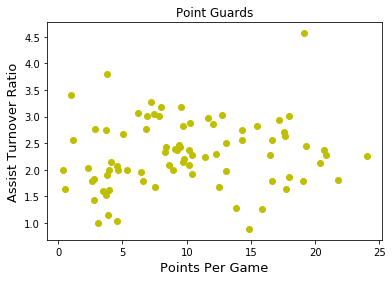

In [87]:
# Use matplotlib to create a scatter plot with Points Per Game (ppg) on the X axis and Assist Turnover Ratio (atr) on the Y axis.
from matplotlib import pyplot as plt


plt.scatter(point_guards['ppg'], point_guards['atr'], c='y')
plt.title("Point Guards")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)
plt.show()


### K-Means Clustering


Step 1 (Assign Points to Clusters) For each player, calculate the Euclidean distance between that player's coordinates, or values for atr & ppg, and each of the centroids' coordinates. Assign the player to the cluster whose centroid is the closest to, or has the lowest Euclidean distance to, the player's values.

Step 2 (Update New Centroids of the Clusters) For each cluster, compute the new centroid by calculating the arithmetic mean of all of the points (players) in that cluster. We calculate the arithmetic mean by taking the average of all of the X values (atr) and the average of all of the Y values (ppg) of the points in that cluster.

Iterate Repeat steps 1 & 2 until the clusters are no longer moving and have converged.

In [88]:
import numpy as np

num_clusters = 5
# Use numpy's random function to generate a list, length: num_clusters, of indices
random_initial_points = np.random.choice(point_guards.index, size=num_clusters)
# Use the random indices to create the centroids
centroids = point_guards.loc[random_initial_points]
point_guards.index

Int64Index([ 24,  29,  30,  38,  50,  52,  60,  64,  71,  76,  78,  82,  85,
             87,  95,  97,  99, 110, 126, 136, 142, 146, 157, 180, 189, 204,
            207, 208, 218, 220, 221, 226, 232, 253, 261, 262, 272, 273, 274,
            278, 279, 280, 283, 290, 293, 299, 306, 312, 322, 325, 328, 337,
            343, 344, 347, 357, 360, 368, 371, 372, 374, 375, 377, 382, 387,
            388, 399, 415, 416, 420, 423, 431, 450, 451, 453, 454, 455, 459,
            462, 465, 467, 471],
           dtype='int64')

Plot the centroids, in addition to the point_guards, so we can see where the randomly chosen centroids started out.



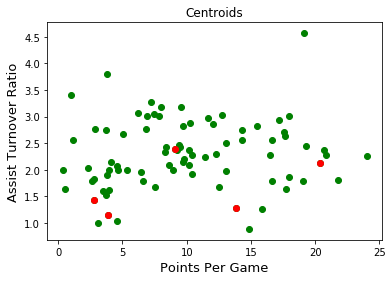

In [89]:
plt.scatter(point_guards['ppg'], point_guards['atr'], c='green')
plt.scatter(centroids['ppg'], centroids['atr'], c='red')
plt.title("Centroids")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)
plt.show()

Create a centriod dictionary with:

key: cluster_id of that centroid's cluster

value: centroid's coordinates expressed as a list ( ppg value first, atr value second )


In [90]:
def centroids_to_dict(centroids):
    dictionary = dict()
    # iterating counter we use to generate a cluster_id
    counter = 0

    # iterate a pandas data frame row-wise using .iterrows()
    for index, row in centroids.iterrows():
        coordinates = [row['ppg'], row['atr']]
        dictionary[counter] = coordinates
        counter += 1

    return dictionary

centroids_dict = centroids_to_dict(centroids)
print(centroids_dict)



{0: [20.34722222222222, 2.131455399061033], 1: [2.7450980392156863, 1.4411764705882353], 2: [9.123287671232877, 2.3833333333333333], 3: [3.869565217391304, 1.1612903225806452], 4: [13.825, 1.27734375]}


In [91]:
# Before we can assign players to clusters, we need a way to compare the ppg and atr values of the players with each cluster's centroi 
# Let's create the function calculate_distance, which takes in 2 lists (the player's values for ppg and atr and the centroid's values for ppg and atr).
import math

def calculate_distance(centroid, player_values):
    root_distance = 0
    
    for x in range(0, len(centroid)):
        difference = centroid[x] - player_values[x]
        squared_difference = difference**2
        root_distance += squared_difference

    euclid_distance = math.sqrt(root_distance)
    return euclid_distance

q = [5, 2]
p = [3,1]

# Sqrt(5) = ~2.24
print(calculate_distance(q, p))


2.23606797749979


In [92]:
# assign data points to clusters based on Euclidean distance

def assign_to_cluster(row):
    lowest_distance = -1
    closest_cluster = -1
    
    for cluster_id, centroid in centroids_dict.items():
        df_row = [row['ppg'], row['atr']]
        euclidean_distance = calculate_distance(centroid, df_row)
        
        if lowest_distance == -1:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id 
        elif euclidean_distance < lowest_distance:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id
    return closest_cluster

point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)

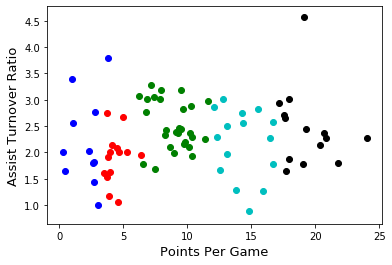

In [93]:
# Let's write a function, visualize_clusters, that we can use to visualize the clusters easily.

# Visualizing clusters
def visualize_clusters(df, num_clusters):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        plt.scatter(clustered_df['ppg'], clustered_df['atr'], c=colors[n-1])
        plt.xlabel('Points Per Game', fontsize=13)
        plt.ylabel('Assist Turnover Ratio', fontsize=13)
    plt.show()

visualize_clusters(point_guards, 5)

In [94]:
# Step 2 (Update New Centroids of the Clusters) For each cluster, compute the new centroid by calculating the arithmetic mean of all of the points (players) in that cluster. 
# We calculate the arithmetic mean by taking the average of all of the X values (atr) and the average of all of the Y values (ppg) of the points in that cluster.

def recalculate_centroids(df):
    new_centroids_dict = dict()
    # 0..1...2...3...4
    for cluster_id in range(0, num_clusters):
        # Finish the logic
        return new_centroids_dict

centroids_dict = recalculate_centroids(point_guards)
def recalculate_centroids(df):
    new_centroids_dict = dict()
    
    for cluster_id in range(0, num_clusters):
        values_in_cluster = df[df['cluster'] == cluster_id]
        # Calculate new centroid using mean of values in the cluster
        new_centroid = [np.average(values_in_cluster['ppg']), np.average(values_in_cluster['atr'])]
        new_centroids_dict[cluster_id] = new_centroid
    return new_centroids_dict

centroids_dict = recalculate_centroids(point_guards)

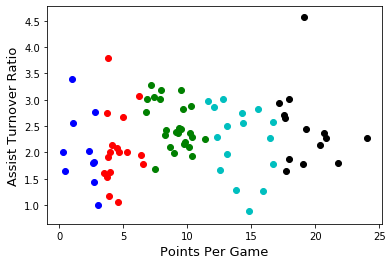

In [95]:
# Now that we recalculated the centroids, let's re-run Step 1 (assign_to_cluster) and see how the clusters shifted.
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)


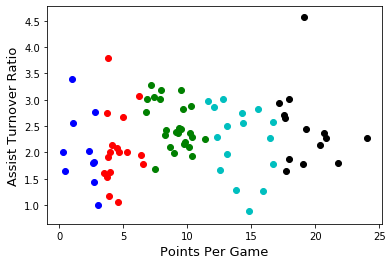

In [96]:
#recal
centroids_dict = recalculate_centroids(point_guards)
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)

As you repeat Steps 1 and 2 and run visualize_clusters, you'll notice that a few of the points are changing clusters between every iteration (especially in areas where 2 clusters almost overlap), but otherwise, the clusters visually look like they don't move a lot after every iteration. This means 2 things:

K-Means doesn't cause massive changes in the makeup of clusters between iterations, meaning that it will always converge and become stable
Because K-Means is conservative between iterations, where we pick the initial centroids and how we assign the players to clusters initially matters a lot

To counteract these problems, the sklearn implementation of K-Means does some intelligent things like re-running the entire clustering process lots of times with random initial centroids so the final results are a little less biased on one passthrough's initial centroids.

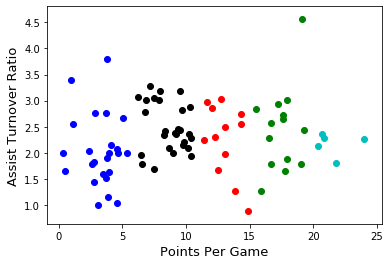

In [98]:

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(point_guards[['ppg', 'atr']])
point_guards['cluster'] = kmeans.labels_

visualize_clusters(point_guards, num_clusters)